In [26]:
import hdf5storage
import numpy as np

data = hdf5storage.loadmat('indy_20160930_02.mat')

In [27]:
from utils import not_moving_filter, get_bins, get_angles, collect_spikes, get_velocity, get_position

In [38]:
time_bin = 0.1
angle_bin = 40
spike_num_threshold = 300
good_score = 0.5
good_neurons = False
bin_delay = 2

mask = np.ones_like(data['cursor_pos'])
time_bin_indexs = get_bins(data['t'], time_bin, mask)
angle_vecs = get_angles(data['cursor_pos'], time_bin_indexs)

In [39]:
spike_nums = []
if not good_neurons:
    for channel_id, channel in enumerate(data['spikes']):
        for i, neuron in enumerate(channel):
            if i == 0:
                continue
            spikes = neuron.flatten()
            if len(spikes) < spike_num_threshold:
                continue
            spike_num = collect_spikes(spikes, time_bin_indexs, data['t'])
            spike_nums.append(spike_num)
    spike_nums = np.stack(spike_nums, axis=1)
else:
    good_neuron_index = np.load('good_neurons.npy')
    for channel_id, neuron_id in good_neuron_index:
        spikes = data['spikes'][channel_id][neuron_id].flatten()
        spike_num = collect_spikes(spikes, time_bin_indexs, data['t'])
        spike_nums.append(spike_num)
    spike_nums = np.stack(spike_nums, axis=1)

In [40]:
velocities = get_velocity(data['cursor_pos'], data['t'], time_bin_indexs)
positions = get_position(data['cursor_pos'], data['t'], time_bin_indexs)
motion = np.concatenate([velocities, positions], axis=1)
motion.shape

(4607, 4)

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
print(spike_nums.shape)
spike_component = pca.fit_transform(spike_nums)
pca.explained_variance_ratio_

(4607, 130)


array([0.14936738, 0.04482194])

In [35]:
def correlation(y_true, y_pred):
    '''
    y_true.shape = y_pred.shape = [N, d]
    calculate the correlation of each feature
    '''
    corr = np.array([np.corrcoef(y_true[:, i], y_pred[:, i])[0, 1] for i in range(y_true.shape[1])])
    return corr.mean()

## 1. Linear Regression

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error
# normalize spike number for linear regression
spike_norm = spike_nums / np.max(spike_nums)
model = LinearRegression()
res = model.fit(spike_norm[:-bin_delay], motion[bin_delay:])
motion_pred = model.predict(spike_norm[:-bin_delay])
print('R2 score = ', r2_score(motion[bin_delay:], motion_pred))
print('RMSE score = ', root_mean_squared_error(motion[bin_delay:], motion_pred))
print('correlation = ', correlation(motion[bin_delay:], motion_pred))

R2 score =  0.38516673372765453
RMSE score =  42.209401109777
correlation =  0.6190027508709713


## 2. Kalman Filter

In [42]:
from sklearn.linear_model import LinearRegression
from utils import linear_fit
from sklearn.metrics import r2_score
motion_x = motion[:-1]
motion_y = motion[1:]
state_matrix = linear_fit(motion_x, motion_y)
print(state_matrix.shape)
print(r2_score(motion_y, motion_x @ state_matrix))

(4, 4)
0.7818781198217983


In [43]:
observe_matrix = linear_fit(motion[bin_delay:], spike_nums[:-bin_delay])
print(observe_matrix.shape)
r2_score((spike_nums[:-bin_delay]), motion[bin_delay:] @ observe_matrix)

(4, 130)


-0.06703037896375014

In [44]:
from utils import KalmanFilter
from sklearn.metrics import r2_score, root_mean_squared_error
from scipy.stats import pearsonr

state_diff = motion_y @ state_matrix - motion_x
Q = state_diff.T @ state_diff
observe_diff = spike_nums - motion @ observe_matrix
R = observe_diff.T @ observe_diff

A = state_matrix.T
B = np.zeros_like(A)
H = observe_matrix.T
P = motion[0]
x0 = motion[0]
kf = KalmanFilter(A, B, H, Q, R, P, x0)

y_pred = np.zeros_like(motion)
for i, spike_num in enumerate(spike_nums):
    y_pred[i] = kf.get_state()
    kf.predict()
    kf.update(spike_nums[i])
print('R2 score = ', r2_score(motion, y_pred))
print('RMSE score = ', root_mean_squared_error(motion, y_pred))
print('correlation = ', correlation(motion, y_pred))

R2 score =  0.4985401528820821
RMSE score =  39.305478875843285
correlation =  0.7323891426005142


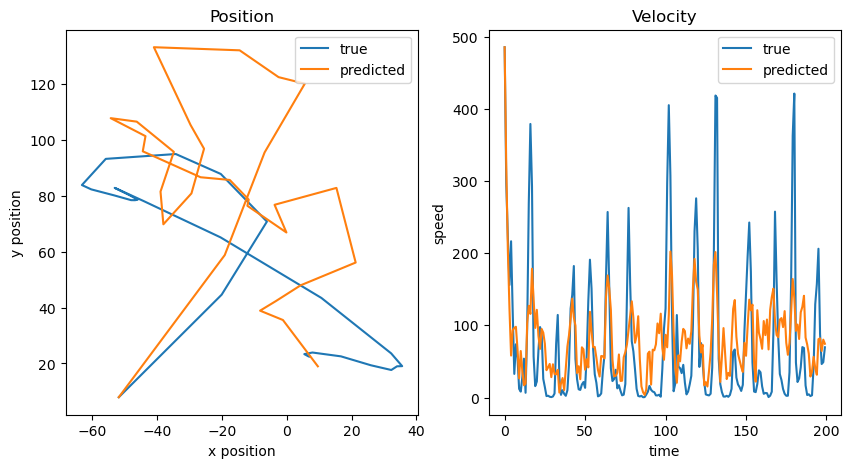

In [22]:
import matplotlib.pyplot as plt

plot, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(motion[:30, 2], motion[:30, 3], label='true')
ax1.plot(y_pred[:30, 2], y_pred[:30, 3], label='predicted')
ax1.legend(loc='upper right')
ax1.set_title('Position')
ax1.set_xlabel('x position')
ax1.set_ylabel('y position')
ax2.plot(np.linalg.norm(motion[:200, :2], axis=1), label='true')
ax2.plot(np.linalg.norm(y_pred[:200, :2], axis=1), label='predicted')
ax2.set_title('Velocity')
ax2.set_xlabel('time')
ax2.set_ylabel('speed')
ax2.legend(loc='upper right')
plt.savefig('kalman.png')

## 3. Linear Filter

In [46]:
past_bins = 5
spike_histories = []
for i in range(past_bins - 1, len(spike_nums)):
    spike_history = spike_nums[i - past_bins + 1: i + 1].flatten()
    spike_histories.append(spike_history)
motion_histories = motion[past_bins - 1:]
spike_histories = np.stack(spike_histories, axis=0)
print(spike_histories.shape, motion_histories.shape)

(4603, 650) (4603, 4)


In [47]:
from utils import linear_fit
from sklearn.metrics import r2_score, root_mean_squared_error
weight = linear_fit(spike_histories, motion_histories)
print('R2 score = ', r2_score(motion_histories, spike_histories @ weight))
print('RMSE score = ', root_mean_squared_error(motion_histories, spike_histories @ weight))
print('correlation = ', correlation(motion_histories, spike_histories @ weight))

R2 score =  0.6834223500898651
RMSE score =  30.692288642095168
correlation =  0.8266115498880247


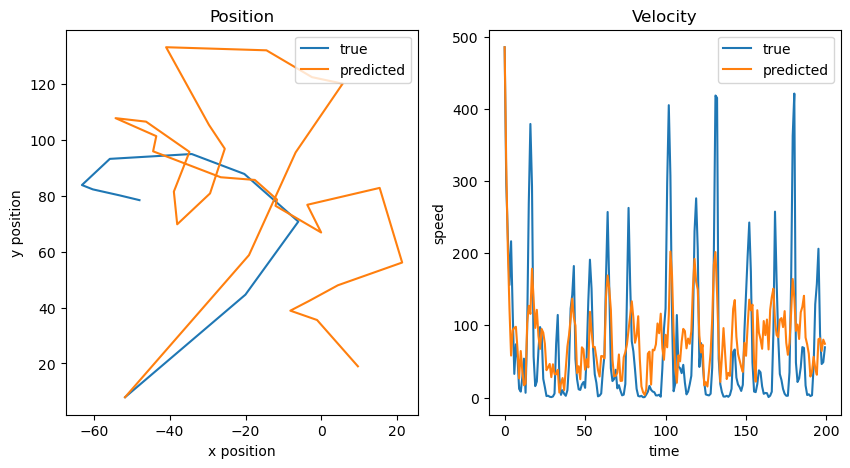

In [21]:
import matplotlib.pyplot as plt

plot, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(motion[:10, 2], motion[:10, 3], label='true')
ax1.plot(y_pred[:30, 2], y_pred[:30, 3], label='predicted')
ax1.set_title('Position')
ax1.set_xlabel('x position')
ax1.set_ylabel('y position')
ax1.legend(loc='upper right')
ax2.plot(np.linalg.norm(motion[:200, :2], axis=1), label='true')
ax2.plot(np.linalg.norm(y_pred[:200, :2], axis=1), label='predicted')
ax2.set_title('Velocity')
ax2.set_xlabel('time')
ax2.set_ylabel('speed')
ax2.legend(loc='upper right')

## 4. Effect of Time Bin

In [23]:
time_bins = [0.025, 0.05, 0.1, 0.15, 0.2, 0.25]

square_scores = []
kalman_scores = []
linear_scores = []

for time_bin in time_bins:
    print(f'time bin = {time_bin}')
    
    time_bin_indexs = get_bins(data['t'], time_bin, mask)
    velocities = get_velocity(data['cursor_pos'], data['t'], time_bin_indexs)
    positions = get_position(data['cursor_pos'], data['t'], time_bin_indexs)
    motion = np.concatenate([velocities, positions], axis=1)
    spike_nums = []
    for channel_id, channel in enumerate(data['spikes']):
        for i, neuron in enumerate(channel):
            if i == 0:
                continue
            spikes = neuron.flatten()
            if len(spikes) < spike_num_threshold:
                continue
            spike_num = collect_spikes(spikes, time_bin_indexs, data['t'])
            spike_nums.append(spike_num)
    spike_nums = np.stack(spike_nums, axis=1)

    # linear regression
    spike_norm = spike_nums / np.max(spike_nums)
    model = LinearRegression()
    res = model.fit(spike_norm[:-bin_delay], motion[bin_delay:])
    square_scores.append([time_bin, res.score(spike_norm[:-bin_delay], motion[bin_delay:])])

    # kalman
    motion_x = motion[:-1]
    motion_y = motion[1:]
    state_matrix = linear_fit(motion_x, motion_y)
    observe_matrix = linear_fit(motion[bin_delay:], spike_nums[:-bin_delay])
    
    state_diff = motion_y @ state_matrix - motion_x
    Q = state_diff.T @ state_diff
    observe_diff = spike_nums - motion @ observe_matrix
    R = observe_diff.T @ observe_diff
    A = state_matrix.T
    B = np.zeros_like(A)
    H = observe_matrix.T
    P = motion[0]
    x0 = motion[0]
    kf = KalmanFilter(A, B, H, Q, R, P, x0)

    y_pred = np.zeros_like(motion)
    for i, spike_num in enumerate(spike_nums):
        y_pred[i] = kf.get_state()
        kf.predict()
        kf.update(spike_nums[i])

    kalman_scores.append([time_bin, r2_score(motion, y_pred)])

    # linear filter
    past_bins = 5
    spike_histories = []
    for i in range(past_bins - 1, len(spike_nums)):
        spike_history = spike_nums[i - past_bins + 1: i + 1].flatten()
        spike_histories.append(spike_history)
    motion_histories = motion[past_bins - 1:]
    spike_histories = np.stack(spike_histories, axis=0)
    weight = linear_fit(spike_histories, motion_histories)
    linear_scores.append([time_bin, r2_score(motion_histories, spike_histories @ weight)])

time bin = 0.025
time bin = 0.05
time bin = 0.1
time bin = 0.15
time bin = 0.2
time bin = 0.25


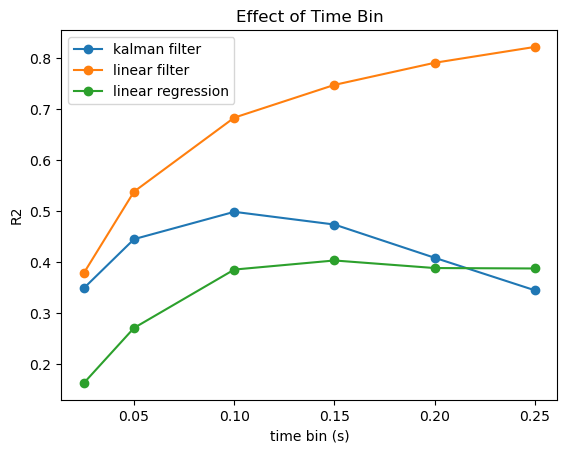

In [25]:
import matplotlib.pyplot as plt

plt.plot(np.array(kalman_scores)[:, 0], np.array(kalman_scores)[:, 1], marker='o', label='kalman filter')
plt.plot(np.array(linear_scores)[:, 0], np.array(linear_scores)[:, 1], marker='o', label='linear filter')
plt.plot(np.array(square_scores)[:, 0], np.array(square_scores)[:, 1], marker='o', label='linear regression')
plt.xlabel('time bin (s)')
plt.ylabel('R2')
plt.title('Effect of Time Bin')
plt.legend()
plt.savefig('time_bin.png')